In [2]:
# Import needed libraries
import csv as C
import numpy as N
import pandas as P
import matplotlib.pyplot as plt

import sklearn.decomposition as SD
import sklearn.preprocessing as SP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import scipy.stats
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from scipy.stats import shapiro

In [3]:
# Load data into a DataFrame
df = P.read_csv("habits.data", sep=";", na_values=['?'])

# Show first rows to see that loading the data was successful
df.head()

,kohde,jasen,pvknro,sp,ASALUE,IKAL1,A1,A2,A3,A4,A5
0,50002,1,2,1,1.0,6,190,450,13,2.0,1.0
1,50002,2,2,2,1.0,6,235,480,52,1.0,1.0
2,50009,1,2,2,1.0,7,175,460,104,1.0,1.0
3,50011,1,2,2,3.0,4,180,460,0,1.0,1.0
4,50012,1,1,2,1.0,8,0,600,10,2.0,2.0


In [4]:
# Show info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kohde   780 non-null    int64  
 1   jasen   780 non-null    int64  
 2   pvknro  780 non-null    int64  
 3   sp      780 non-null    int64  
 4   ASALUE  780 non-null    float64
 5   IKAL1   780 non-null    int64  
 6   A1      773 non-null    object 
 7   A2      770 non-null    object 
 8   A3      776 non-null    object 
 9   A4      740 non-null    float64
 10  A5      742 non-null    float64
dtypes: float64(3), int64(5), object(3)
memory usage: 67.2+ KB


In [5]:
# There are 780 rows and 11 columns. Some columns (A1–A5) have missing values.

In [6]:
# Show number of rows and columns
df.shape

(780, 11)

In [7]:
# Count missing values in each column
df.isna().sum()

kohde      0
jasen      0
pvknro     0
sp         0
ASALUE     0
IKAL1      0
A1         7
A2        10
A3         4
A4        40
A5        38
dtype: int64

In [8]:
# Activity variables A1–A3 show minutes spent on activities.
# Missing values mean no time was spent → replace them with 0.

df[['A1', 'A2', 'A3']] = df[['A1', 'A2', 'A3']].fillna(0)

In [9]:
# A4–A5 are yes/no variables.
# Because many values are missing, replacing them with 0 or 1 would bias the data too much.
# Instead, create a third category for missing values (3 = missing).
df['A4'] = df['A4'].fillna(3).astype('category')
df['A5'] = df['A5'].fillna(3).astype('category')

In [10]:
# Convert selected variables into categorical type
categorical_vars = ['pvknro', 'sp', 'ASALUE', 'IKAL1', "A4", "A5"] 
df[categorical_vars] = df[categorical_vars].astype('category')

In [11]:
# Check updated dataset info after conversions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   kohde   780 non-null    int64   
 1   jasen   780 non-null    int64   
 2   pvknro  780 non-null    category
 3   sp      780 non-null    category
 4   ASALUE  780 non-null    category
 5   IKAL1   780 non-null    category
 6   A1      780 non-null    object  
 7   A2      780 non-null    object  
 8   A3      780 non-null    object  
 9   A4      780 non-null    category
 10  A5      780 non-null    category
dtypes: category(6), int64(2), object(3)
memory usage: 36.5+ KB


In [12]:
# After conversion the variables are now correct.

In [13]:
# Check if activity columns (A1–A3) contain non-numeric values
activity_cols = ['A1', 'A2', 'A3']

for col in activity_cols:
    non_numeric = df[P.to_numeric(df[col], errors='coerce').isna()][col]
    if not non_numeric.empty:
        print(f"Non-numeric values in {col}:")
        print(non_numeric.unique())
    else:
        print(f"All values in {col} are numeric.")

Non-numeric values in A1:
['00:00' '07:00' '05:45' '09:20' '07:20' '08:50' '10:10' '06:10' '07:40'
 '03:05' '01:30' '06:50' '01:50' '15:10' '04:15' '09:10' '03:00' '03:40'
 '03:45' '03:20' '07:50']
Non-numeric values in A2:
['09:20' '09:30' '06:20' '09:40' '09:00' '11:00' '08:10' '07:40' '08:40'
 '06:10' '08:30' '11:40' '07:20' '07:50' '12:00' '08:50' '11:20' '10:40'
 '04:20' '09:10' '10:50' '08:00' '10:00' '06:00' '07:10' '06:30' '10:20'
 '10:30' '11:10' '10:10' '09:50' '14:20' '13:30' '04:00' '04:30']
Non-numeric values in A3:
['00:00' '02:20' '01:05' '01:18' '00:30' '00:20' '09:00' '00:10' '00:39'
 '01:00' '00:13' '00:50' '00:40' '01:40' '02:10' '01:44' '00:52' '01:31'
 '02:50' '03:30' '01:10' '03:41' '03:10']


In [14]:
# Some time values are in hh:mm format rather than just minutes.

In [15]:
print(df[df['A1'] == '01:30'])

     kohde  jasen pvknro sp ASALUE IKAL1     A1     A2     A3   A4   A5
454  51242      2      1  2    1.0     4  01:30  10:10  00:10  1.0  1.0


In [16]:
print(df.loc[454])

kohde     51242
jasen         2
pvknro        1
sp            2
ASALUE      1.0
IKAL1         4
A1        01:30
A2        10:10
A3        00:10
A4          1.0
A5          1.0
Name: 454, dtype: object


In [17]:
df.head(10)

,kohde,jasen,pvknro,sp,ASALUE,IKAL1,A1,A2,A3,A4,A5
0,50002,1,2,1,1.0,6,190,450,13,2.0,1.0
1,50002,2,2,2,1.0,6,235,480,52,1.0,1.0
2,50009,1,2,2,1.0,7,175,460,104,1.0,1.0
3,50011,1,2,2,3.0,4,180,460,0,1.0,1.0
4,50012,1,1,2,1.0,8,0,600,10,2.0,2.0
5,50015,1,1,1,3.0,8,0,480,310,2.0,1.0
6,50015,2,1,2,3.0,8,0,520,40,2.0,1.0
7,50022,1,1,2,1.0,6,480,570,0,2.0,1.0
8,50024,1,2,1,1.0,4,340,490,0,2.0,1.0
9,50030,1,2,1,2.0,6,0,570,91,1.0,1.0


In [18]:
def convert_to_minutes(val):
    try:
        # Try to convert directly to float (works for numeric values)
        return float(val)
    except:
        # If it fails, assume it's in hh:mm format
        if isinstance(val, str) and ':' in val:
            h, m = val.split(':')
            return int(h) * 60 + int(m)
        return P.NA  # Return NA for anything unexpected

activity_cols = ['A1', 'A2', 'A3']

for col in activity_cols:
    df[col] = df[col].apply(convert_to_minutes)

In [19]:
# Assign descriptive labels to categorical variables for better readability
df["sp"] = df["sp"].map({1: "Male", 2: "Female"}).astype("category")
df["pvknro"] = df["pvknro"].map({1: "working day", 2: "weekend"}).astype("category")
df["ASALUE"] = df["ASALUE"].map({1: "city", 2: "municipality", 3: "rural area"}).astype("category")
df["IKAL1"] = df["IKAL1"].map({1: "10-14", 2: "15-19", 3: "20-24", 4: "25-34", 5: "35-44", 6: "45-54", 7: "55-64", 8: "65-74", 9: "75-"}).astype("category")

# Rename activity columns to more descriptive names
df = df.rename(columns={
    'A1': 'tyo',
    'A2': 'nukkuminen',
    'A3': 'lukeminen',
    'A4': 'ravintolakaynti',
    'A5': 'kirjastokaynti'
})

In [20]:
# Display the first few rows to inspect the cleaned dataset
df.head()

,kohde,jasen,pvknro,sp,ASALUE,IKAL1,tyo,nukkuminen,lukeminen,ravintolakaynti,kirjastokaynti
0,50002,1,weekend,Male,city,45-54,190.0,450.0,13.0,2.0,1.0
1,50002,2,weekend,Female,city,45-54,235.0,480.0,52.0,1.0,1.0
2,50009,1,weekend,Female,city,55-64,175.0,460.0,104.0,1.0,1.0
3,50011,1,weekend,Female,rural area,25-34,180.0,460.0,0.0,1.0,1.0
4,50012,1,working day,Female,city,65-74,0.0,600.0,10.0,2.0,2.0


In [21]:
# Check how many observations there are for each sex
print(df["sp"].value_counts())

sp
Female    406
Male      374
Name: count, dtype: int64


In [22]:
# Check the number of observations in each age group
print(df["IKAL1"].value_counts())

IKAL1
45-54    170
55-64    165
35-44    132
65-74    112
25-34    106
75-       61
20-24     34
Name: count, dtype: int64


In [23]:
# Check the number of observations for working days vs. weekends
print(df["pvknro"].value_counts())

pvknro
working day    418
weekend        362
Name: count, dtype: int64


In [24]:
# Check the number of observations in each area type
print(df["ASALUE"].value_counts())

ASALUE
city            519
rural area      137
municipality    124
Name: count, dtype: int64


In [25]:
# Count how many people recorded sleeping time
num_slept = (df['nukkuminen'] > 0).sum()
print(f"Number of people who slept: {num_slept}")

Number of people who slept: 770


In [26]:
# Count how many people recorded working time
num_worked = (df['tyo'] > 0).sum()
print(f"Number of people who worked: {num_worked}")

Number of people who worked: 195


In [27]:
# Count how many people recorded reading time
num_read = (df['lukeminen'] > 0).sum()
print(f"Number of people who read: {num_read}")

Number of people who read: 511


In [28]:
print(df["ravintolakaynti"].value_counts())

ravintolakaynti
1.0      365
2.0      357
3.0       40
0.0        5
120.0      5
240.0      4
60.0       2
180.0      2
Name: count, dtype: int64


In [29]:
print(df["kirjastokaynti"].value_counts())

kirjastokaynti
1.0      491
2.0      233
3.0       38
0.0       14
120.0      2
180.0      2
Name: count, dtype: int64


In [30]:
# We can assume that the 2 variables (A4/A5) are yes/no (1 = yes/2 = no) variables. In that case we are only interested whether the person 
# Has gone to the restaurant/library or not. Therefore we can replace the assumed minutes spent on the activity with yes values (1), and 0 values
#(0 minutes spent on activity) with no values (2). We keep 3 as its own missing values variable.

# Convert values to yes/no (1 = yes, 0 = no)
df["ravintolakaynti"] = df["ravintolakaynti"].apply(lambda x: 1 if x in [1, 60, 120, 180, 240] else (2 if x in [0, 2] else x))
df["kirjastokaynti"] = df["kirjastokaynti"].apply(lambda x: 1 if x in [1, 120, 180] else (2 if x in [0, 2] else x))

# Verify conversion
print(df["ravintolakaynti"].value_counts())
print(df["kirjastokaynti"].value_counts())

ravintolakaynti
1.0    378
2.0    362
3.0     40
Name: count, dtype: int64
kirjastokaynti
1.0    495
2.0    247
3.0     38
Name: count, dtype: int64


In [31]:
# The dataset includes individuals of different sexes, age groups, and areas of residence. Observations are made in both working days and weekends. 
# Most participants are middle-aged (45-64) and live in cities.
# The majority of participants live in cities, with fewer from rural areas or municipalities.
# About half of the known participants visited a restaurant (378 vs 362)
# Clearly more participants visited a library rather than didn't. (495 vs 247) 


In [32]:
# Estimate how much time on average Finnish households spend daily on each activity.
# Estimate the mean for activity variables A1–A3
# A4–A5 are categorical (yes/no), so calculating the mean is not meaningful

In [33]:
# Calculate the average time spent per day on each activity (work, sleep, reading)
activity_averages = df[['tyo', 'nukkuminen', 'lukeminen']].mean()
print("Average minutes per activity per day:")
print(activity_averages)

Average minutes per activity per day:
tyo            77.987179
nukkuminen    522.461538
lukeminen      56.652564
dtype: float64


In [34]:
# On average, participants spent about 78 minutes per day working, 
# indicating that this dataset may include part-time work or people who didn't have jobs during the observation.

# Participants spend most of their time sleeping, as expected, (around 522 mins = 8.7 hours) per day.

# Reading time is relatively low, averaging about 57 minutes per day.

In [35]:
# Calculate the median time spent per day on each activity (work, sleep, reading)
activity_averages = df[['tyo', 'nukkuminen', 'lukeminen']].median()
print("Average minutes per activity per day:")
print(activity_averages)

Average minutes per activity per day:
tyo             0.0
nukkuminen    530.0
lukeminen      30.0
dtype: float64


In [36]:
# The working median is 0 minutes, indicating that more than half of the participants did not record any work during the observed day.

# The sleeping median is 530 minutes (around 8.8 hours), showing that most participants have a consistent and sufficient sleep duration.

# The reading median is 30 minutes, suggesting that while some individuals read more, the typical participant spends a relatively short time reading each day.

In [37]:
# Visualize the distribution of the daily activities to create a clearer picture of the participants' habits.

<Axes: ylabel='Frequency'>

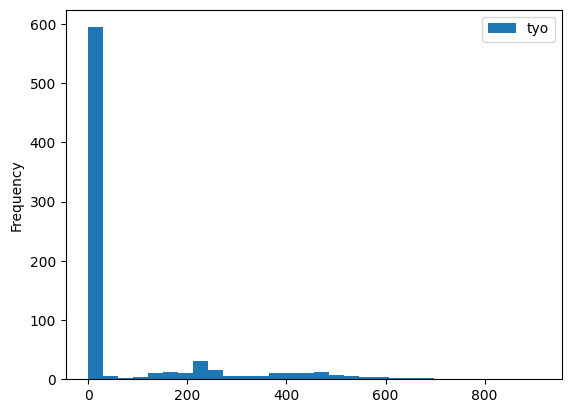

In [38]:
P.DataFrame(df['tyo']).plot(kind="hist",bins=30)

<Axes: ylabel='Frequency'>

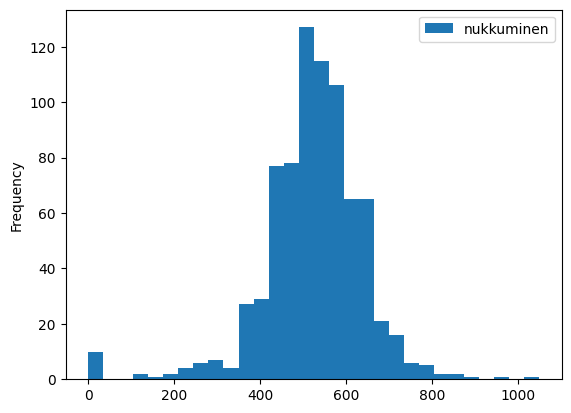

In [39]:
P.DataFrame(df['nukkuminen']).plot(kind="hist",bins=30)

<Axes: ylabel='Frequency'>

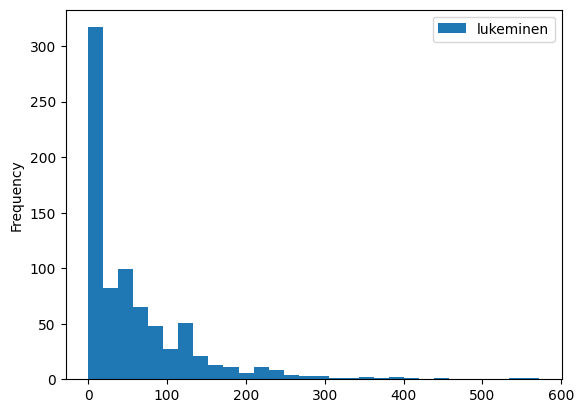

In [40]:
P.DataFrame(df['lukeminen']).plot(kind="hist",bins=30)

In [41]:
# Observing the histograms, we can notice many zero values across working and reading variables.
# This suggests that a large number of participants did not engage in these activities at all.
# Relatively few participants reported working.
# Sleep was more consistently reported, but still some zero values present.
# Reading was not a daily habit for many individuals.
# The high number of zeros is likely due to replacing missing values with zeros earlier.

# To better understand the distribution among participants who actually performed these activities,
# we will redraw the histograms for working and reading, including only the non-zero values. 
# This will give a clearer picture of how much time participants spent when they did engage in these activities.

<Axes: ylabel='Frequency'>

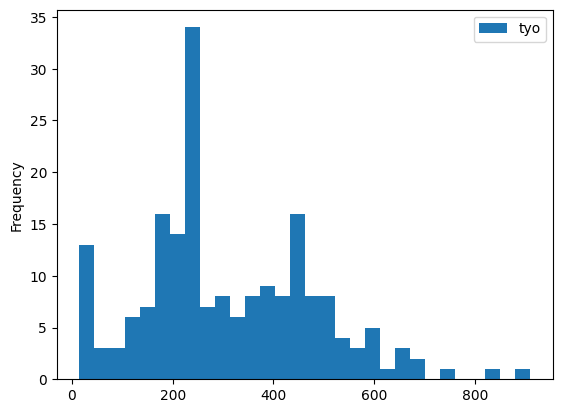

In [42]:
# Visualize work time among participants who actually worked
P.DataFrame(df[df['tyo'] > 0]['tyo']).plot(kind="hist", bins=30)

# The histogram appears slightly right-skewed.
# Most participants who worked spent between 100 and 300 minutes per day working.
# Focusing only on non-zero values gave a slightly more realistic picture of work behavior.

<Axes: ylabel='Frequency'>

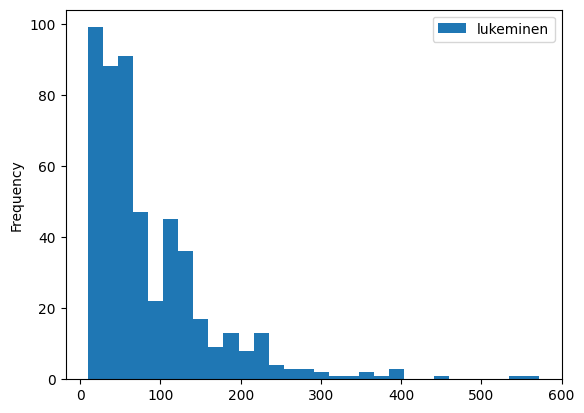

In [43]:
# Visualize reading time among participants who actually read
P.DataFrame(df[df['lukeminen'] > 0]['lukeminen']).plot(kind="hist", bins=30)

# Histogram is heavily right-skewed
# Majority of the participants didnt spend much time reading.
# Some participants spent longer periods of time reading.

In [44]:
#For extra information, let's check for normality with shapiro-wilk test
#h0: the data is normally distributed
#h1: the data is not normally distributed

shapiro_tyo = shapiro(df["tyo"])
shapiro_nukkuminen = shapiro(df["nukkuminen"])
shapiro_lukeminen = shapiro(df["lukeminen"])

print("tyo: ", shapiro_tyo)
print("nukkuminen: ", shapiro_nukkuminen)
print("lukeminen: ", shapiro_lukeminen)

tyo:  ShapiroResult(statistic=np.float64(0.5595244172918816), pvalue=np.float64(2.668828997457301e-40))
nukkuminen:  ShapiroResult(statistic=np.float64(0.9210308096358564), pvalue=np.float64(9.013231576967195e-20))
lukeminen:  ShapiroResult(statistic=np.float64(0.7470982372430457), pvalue=np.float64(7.751246259713364e-33))


In [45]:
#each variable has very small p-values. This suggests that the variables are not normally distributed.

In [46]:
# With respect to which activities do living environments or days of week differ in Finland?

# Compare how much time people spend on different activities depending on their living environment or day of the week.
activity_cols = ['tyo', 'nukkuminen', 'lukeminen']  # adjust as needed

# By living environment
by_env = df.groupby('ASALUE',  observed=False)[activity_cols].mean()

# By day of week
by_day = df.groupby('pvknro',  observed=False)[activity_cols].mean()

print(by_env)
print(by_day)

                    tyo  nukkuminen  lukeminen
ASALUE                                        
city          79.036609  517.013487  58.260116
municipality  73.790323  510.000000  48.330645
rural area    77.810219  554.379562  58.094891
                   tyo  nukkuminen  lukeminen
pvknro                                       
working day  96.291866  520.717703  49.330144
weekend      56.850829  524.475138  65.107735


In [47]:
#Interpretation 1st table:
#People in cities work and read more on average.
#People in municipalities spend less time on every activity compared to the others.
#Rural residents work and read less than people in cities, but sleep the most.

#Interpretation 2nd table:
# Working values drops significantly on weekends.
# Sleeping and reading values increase on weekends.


# lets use kruskal-wallis for a1-a3 (quantitive variables) and group by living environment/day of week
# our variables aren't normally distributed so kruskal-wallis is the best choice


In [48]:

# Split data by living environment
groups_by_asalue = [group for name, group in df.groupby('ASALUE', observed=False)]

# Working
tyo_groups = [group['tyo'] for group in groups_by_asalue]
result = kruskal(*tyo_groups)
print("tyo: ", result)

# Sleeping
sleep_groups = [group['nukkuminen'] for group in groups_by_asalue]
result = kruskal(*sleep_groups)
print("nukkuminen: ", result)

# Reading
reading_groups = [group['lukeminen'] for group in groups_by_asalue]
result = kruskal(*reading_groups)
print("lukeminen: ", result)

tyo:  KruskalResult(statistic=np.float64(0.17423018809073493), pvalue=np.float64(0.9165715976291327))
nukkuminen:  KruskalResult(statistic=np.float64(12.220291615446822), pvalue=np.float64(0.0022202270629427495))
lukeminen:  KruskalResult(statistic=np.float64(0.7747715351541483), pvalue=np.float64(0.6788291741238593))


In [49]:
#Interpretation:
#h0: No significant differences between the groups across living environments.
#h1: At least one group differs 

#If p < 0.05: the difference is statistically significant.
#If p >= 0.05: you can't say the difference is statistically meaningful.

# tyo:
# p = 0.9166 
# No significant difference in work time across living environments. H₀ is not rejected.

# nukkuminen:
# p = 0.0022 
# There is a significant difference in sleep time across living environments. 
# H₀ is rejected. 

# lukeminen: 
# p = 0.6788 
# No significant difference in reading time across living environments. H₀ is not rejected.

In [50]:
#day of week

# Split data by day of week
groups_by_pvknro = [group for name, group in df.groupby('pvknro', observed=False)]

# Working
tyo_groups = [group['tyo'] for group in groups_by_pvknro]
result = kruskal(*tyo_groups)
print("tyo: ", result)

# Sleeping
sleep_groups = [group['nukkuminen'] for group in groups_by_pvknro]
result = kruskal(*sleep_groups)
print("nukkuminen: ", result)

# Reading
reading_groups = [group['lukeminen'] for group in groups_by_pvknro]
result = kruskal(*reading_groups)
print("lukeminen: ", result)

tyo:  KruskalResult(statistic=np.float64(0.14449162962723844), pvalue=np.float64(0.7038559348375666))
nukkuminen:  KruskalResult(statistic=np.float64(0.11272829703214582), pvalue=np.float64(0.7370591342800268))
lukeminen:  KruskalResult(statistic=np.float64(3.6684521385111983), pvalue=np.float64(0.05545165873935582))


In [51]:
#Interpretation:
#h0: No significant differences between the groups depending of day of week (working day/weekend)
#h1: At least one group differs 

#If p < 0.05: the difference is statistically significant.
#If p >= 0.05: you can't say the difference is statistically meaningful.

# tyo:
# p = 0.7039 
# No significant difference in work time depending day of the week. H₀ is not rejected.


# nukkuminen:
# p = 0.7371 
# No significant difference in sleep time depending day of the week. H₀ is not rejected.

# lukeminen: 
# p = 0.0555 
# This is just above the 0.05 threshold. Technically this means we can't reject h0, but the evidence is quite weak. 
# So: there's weak evidence that there is no significant difference in reading time depending on the day of the week. 


In [52]:
#Let's do similar tests for variables ravintolakaynti and kirjastokaynti. These are categorical yes/no variables
# so we're gonna use chi-square test of independence

# Let's first test by living environment
# h0: there is no association between living environment and the activity
# h1: there is an association between living environment and the activity

#If p < 0.05: there is statistically significant association 
#If p >= 0.05: no evidence of an association

In [53]:
# Ravintolakäynti - ASALUE
contingency_ravintola = P.crosstab(df['ASALUE'], df['ravintolakaynti'])
result = chi2_contingency(contingency_ravintola)
print("Ravintolakaynti: ", result)

# Kirjastokäynti - ASALUE
contingency_kirjasto = P.crosstab(df['ASALUE'], df['kirjastokaynti'])
result = chi2_contingency(contingency_kirjasto)
print("Kirjastokäynti: ", result)



Ravintolakaynti:  Chi2ContingencyResult(statistic=np.float64(17.969579488380216), pvalue=np.float64(0.0012511066057380447), dof=4, expected_freq=array([[251.51538462, 240.86923077,  26.61538462],
       [ 60.09230769,  57.54871795,   6.35897436],
       [ 66.39230769,  63.58205128,   7.02564103]]))
Kirjastokäynti:  Chi2ContingencyResult(statistic=np.float64(7.797304602312722), pvalue=np.float64(0.09929181141224044), dof=4, expected_freq=array([[329.36538462, 164.35      ,  25.28461538],
       [ 78.69230769,  39.26666667,   6.04102564],
       [ 86.94230769,  43.38333333,   6.67435897]]))


In [54]:
#ravintolakaynti:
# p = 0.00125
# h0 is rejected -> evidence of statistically significant association. The living environment affects restaurant visits.

#kirjastokaynti:
#p = 0.0993
# h0 isn't rejected -> there is no statistically significant evidence, that library visits are affected by living environment.¨¨


#Let's then test by day of week (working day/weekend)
# h0: there is no association between day of week and the activity
# h1: there is an association between day of week and the activity

#If p < 0.05: there is statistically significant association 
#If p >= 0.05: no evidence of an association

In [55]:
# By day of week
# Ravintolakäynti - pvknro
contingency_ravintola = P.crosstab(df['pvknro'], df['ravintolakaynti'])
result = chi2_contingency(contingency_ravintola)
print("Ravintolakaynti: ", result)

# Kirjastokäynti - pvknro
contingency_kirjasto = P.crosstab(df["pvknro"], df['kirjastokaynti'])
result = chi2_contingency(contingency_kirjasto)
print("Kirjastokäynti: ", result)

#Day of the week does not affect these binary activities.
#Any differences seen in descriptive means are likely due to random variation rather than systematic trends.

Ravintolakaynti:  Chi2ContingencyResult(statistic=np.float64(1.6866698270132074), pvalue=np.float64(0.4302732041733658), dof=2, expected_freq=array([[202.56923077, 193.99487179,  21.43589744],
       [175.43076923, 168.00512821,  18.56410256]]))
Kirjastokäynti:  Chi2ContingencyResult(statistic=np.float64(1.5838561362950205), pvalue=np.float64(0.4529705946187018), dof=2, expected_freq=array([[265.26923077, 132.36666667,  20.36410256],
       [229.73076923, 114.63333333,  17.63589744]]))


In [56]:
#ravintolakaynti:
# p = 0.4303
# h0 isn't rejected -> there is no statistically significant evidence, that the day of week affects restaurant visits.

#kirjastokaynti:
#p = 0.453
# h0 isn't rejected -> there is no statistically significant evidence, that library visits are affected by day of week.

In [57]:
# sumamry table of these results
summary_data = {
    "Activity": ["tyo", "nukkuminen", "lukeminen", "ravintolakaynti", "kirjastokaynti"],
    "By ASALUE": [
        "ns",  # ns = not significant
        "significant",
        "ns",
        "significant",
        "ns"
    ],
    "By pvknro": [
        "ns",
        "ns",
        "borderline",
        "ns",
        "ns"
    ]
}

summary_df = P.DataFrame(summary_data)
summary_df

,Activity,By ASALUE,By pvknro
0,tyo,ns,ns
1,nukkuminen,significant,ns
2,lukeminen,ns,borderline
3,ravintolakaynti,significant,ns
4,kirjastokaynti,ns,ns


In [58]:
#Which activities are associated with each other in Finnish population?

# Let's start with the a1-a3 variables (tyo, nukkuminen, lukeminen) 
# As stated before, these variables were not normally distributed. Therefore let's explore correlations between the variables using 
# spearman correlation. 

# work and sleeping
cor1 = scipy.stats.spearmanr(df["tyo"], df["nukkuminen"])
print(cor1)

# work and reading
cor2 = scipy.stats.spearmanr(df["tyo"], df["lukeminen"])
print(cor2)

# sleeping and reading
cor3 = scipy.stats.spearmanr(df["nukkuminen"], df["lukeminen"])
print(cor3)

SignificanceResult(statistic=np.float64(-0.33073275889810755), pvalue=np.float64(2.3013582746190667e-21))
SignificanceResult(statistic=np.float64(-0.2099545498707055), pvalue=np.float64(3.2112392771674394e-09))
SignificanceResult(statistic=np.float64(0.02360178449654967), pvalue=np.float64(0.5104118573760911))


In [59]:
#Interpretation

# work - sleep
# r = -0.33
# Weak/semi moderate negative correlation
# People who spend more time working possibly sleep less and other way around. 

# Work - reading
# r = - 0.21
# Weak negative correlation
# People who work more possibly read less and other way around. The relationship is very weak though

# Sleep - reading
# r = 0.02
# The value is basically 0 -> no correlation
# No association between how much people sleep and how much they read

In [60]:
# Let's check if a4 and a5 are associated with each other using chi-square test. These variables are categorical so 
# we can't check for correlation in a same way as numerical variables

In [61]:
# Restaurant visit and a library visit
contingency = P.crosstab(df["ravintolakaynti"], df["kirjastokaynti"])
result = chi2_contingency(contingency)
print(result)



Chi2ContingencyResult(statistic=np.float64(619.0564887323878), pvalue=np.float64(1.1633022993326842e-132), dof=4, expected_freq=array([[239.88461538, 119.7       ,  18.41538462],
       [229.73076923, 114.63333333,  17.63589744],
       [ 25.38461538,  12.66666667,   1.94871795]]))


In [62]:
# Interpretation
# h0: there is no association between restaurant and library visits
# h1: there is an association between restaurant and library visit

# the p-value is very small. This rejects the h0.
# There is a statistically significant association between restaurant and library visit. 
# People who go to restaurant are either more or less likely to also visit libraries (and other way around)


In [63]:
numerical = ["tyo", "nukkuminen", "lukeminen"]
categorical = ["ravintolakaynti", "kirjastokaynti"]
    
# Loop through combinations
for c in categorical:
    print(f"\nResults for {c}:")
    for n in numerical:
        group1 = df[df[c] == 1][n]
        group2 = df[df[c] == 2][n]

        # Perform Mann-Whitney U test
        stat, p = scipy.stats.mannwhitneyu(group1, group2, alternative='two-sided')
        print(f"{n}: U={stat:.2f}, p={p:.4f}")


Results for ravintolakaynti:
tyo: U=78424.50, p=0.0000
nukkuminen: U=63121.00, p=0.0683
lukeminen: U=63327.50, p=0.0736

Results for kirjastokaynti:
tyo: U=64167.00, p=0.1425
nukkuminen: U=55656.50, p=0.0464
lukeminen: U=61723.00, p=0.8265


In [80]:
#interpretation

# RESTAURANT VISITS:
# h0: the distributions of the numerical variables are the same for people who visit a restaurant vs those who don't
# h1: the distributions differ between the two groups

# tyo:
# h0 rejects -> significant difference
# people who visit restaurants spend more or less time working than those who don't

# nukkuminen:
# h0 doesn't reject -> no significant difference
# there's no strong evidence of a difference in sleep between restaurant visitors and those who don't

# lukeminen: 
# h0 doesn't reject -> no significant difference
# no strong evidence of a difference in reading time between restaurant visitors and those who don't


# LIBRARY VISITS:
# h0: the distributions of the numerical variables are the same for people who visit a library vs those who don't
# h1: the distributions differ between the two groups

# tyo:
# h0 doesn't reject -> no significant difference
# No strong evidence of a difference in working time between library visitors and those who don't

# nukkuminen:
# h0 rejects -> significant difference
# People who visit libraries might sleep slightly more or less compared to those who don't

# lukeminen: 
# h0 doesn't reject -> no significant difference
# no strong evidence of a difference in reading time between library visitors and those who don'taw<


C:\Users\saaga\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='0', ylabel='1'>

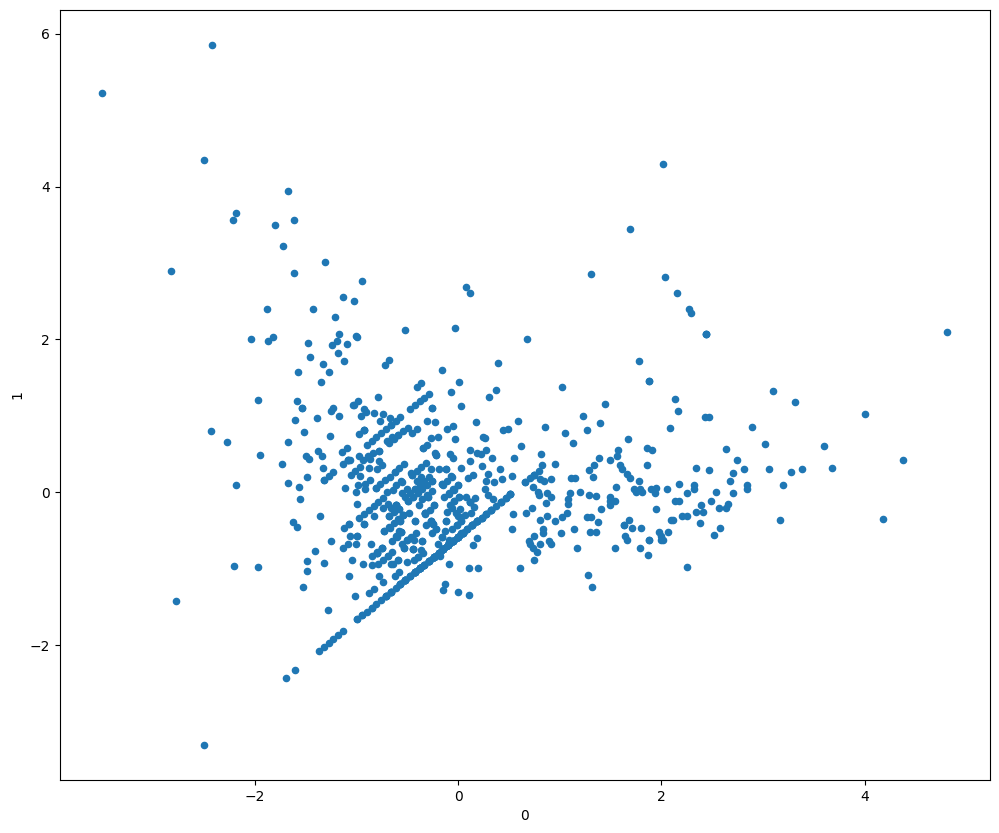

In [79]:
# Let's perform pca for the numerical activity columns. The remining categorical ones aren't meaningful for pca. 
activity_cols = ['tyo', 'nukkuminen', 'lukeminen']

df_original = df[activity_cols]
df_standardised = SP.StandardScaler().fit(df_original).transform(df_original)
pca = SD.PCA().fit(df_standardised)
df_pca = P.DataFrame(pca.transform(df_standardised))
df_extended = P.concat([df, df_pca], axis=1)

df_extended.plot.scatter(0, 1, colormap='brg', figsize=(12,10))

<Axes: xlabel='0', ylabel='1'>

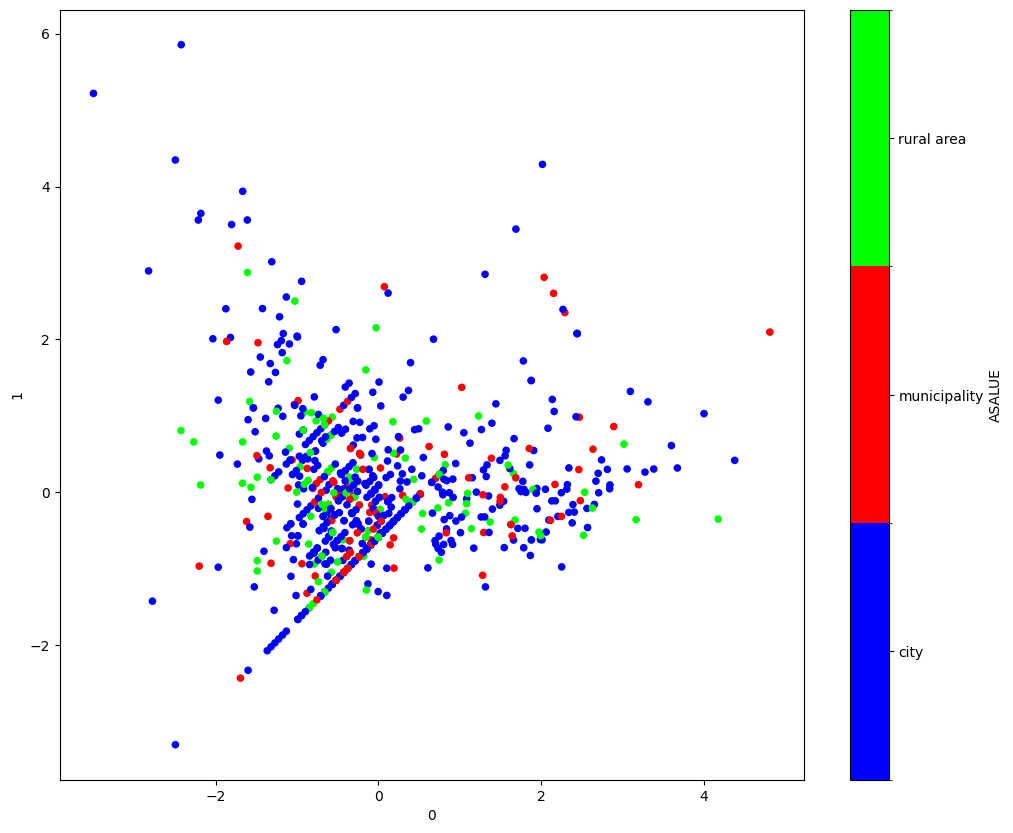

In [74]:
df_extended.plot.scatter(0, 1, c='ASALUE', colormap='brg', figsize=(12,10))

<Axes: xlabel='0', ylabel='1'>

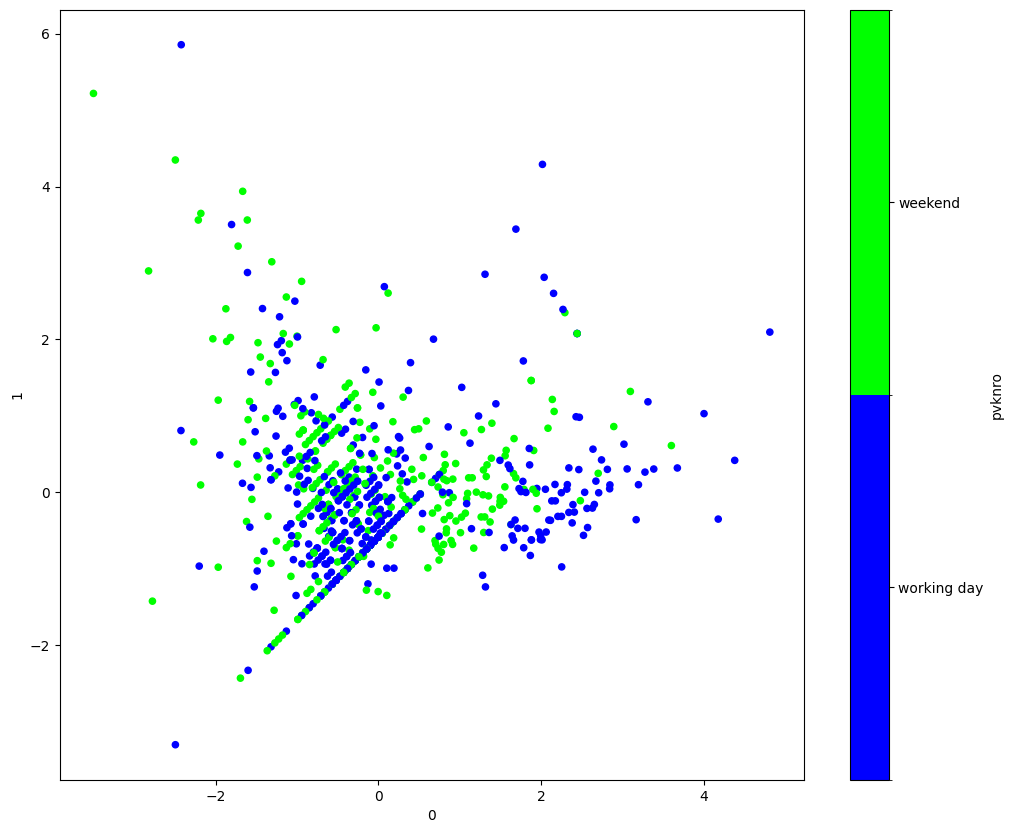

In [70]:

df_extended.plot.scatter(0, 1, c='pvknro', colormap='brg', figsize=(12,10))

In [ ]:
# These plots show the colours very mixed together, and it doesn't seem like there really is any distinct groups.
# Based on this, it seems like participants don't have any strong differences in their activities between living environments 
# or day of the week. 
# This also makes sense with the correlation results:
# the activity variables are weakly correlated -> there is no distinct groups

In [77]:
P.DataFrame(pca.components_, columns=df_original.columns)

#These components are clearly each different. 
# 0 = tyo is clearly more important than the two other activities (people who work more and sleeps/reads less)
# 1 = tyo is basically zero while nukkuminen is strongly negative and lukeminen is strongly positive. (people who read more while sleeping less, 
# and work has basically no effect)
# 2 = all activities are positive and relatively similar. (people who spend time across all activites more evenly) 

# the first component matches the negative correlations of work with sleep (-0.33) and reading (-0.21)

,tyo,nukkuminen,lukeminen
0,0.703369,-0.560716,-0.436887
1,0.005549,-0.610269,0.792175
2,0.710804,0.559615,0.426132


In [76]:
print(df_pca.corr(method='pearson'), end="\n\n")

              0             1             2
0  1.000000e+00  6.588787e-17  1.606590e-16
1  6.588787e-17  1.000000e+00 -2.590360e-16
2  1.606590e-16 -2.590360e-16  1.000000e+00

